In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import src.modules as module
from src.optimizer import SGD
import math
import matplotlib.pyplot as plt

In [3]:
torch.set_grad_enabled(False)

## Generate Dataset

In [4]:
def generate_disc_set(nb):
    input = torch.Tensor(nb, 2).uniform_(0, 1)
    #TODO not sure about centering the circle, maybe remove 0.5 in sub()
    target = abs(input.pow(2).sum(1).sub(0.5+1 / (2*math.pi)).sign().add(-1).div(2))
    return input, target

In [5]:
N = 1000
train_input, train_target = generate_disc_set(N)
train_target = train_target.view(N,1)
test_input, test_target = generate_disc_set(N)
test_target = test_target.view(N,1)

mean, std = train_input.mean(), train_input.std()

train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)

print(train_target[train_target>0.5].sum().long())

tensor(512)


In [6]:
def initialize_model():
    model = module.Sequential(('lin1',module.Linear(2,25,bias=False)),('relu1',module.ReLU()),
                              ('lin2',module.Linear(25,25,bias=False)),('relu2',module.ReLU()),
                              ('lin3',module.Linear(25,25,bias=False)),('relu3',module.ReLU()),
                              ('lin4',module.Linear(25,2,bias=False)),('tanh1',module.Tanh()))
    return model

In [7]:
def train(inp, target, model, epochs, learning_rate=0.0001):
    optim = SGD(model.parameters(), lr=learning_rate)
    loss = module.LossMSE()
    error = []
    for i in range(epochs):
        #print("Epoch {0}".format(i))
        out = model(inp)
        #print("Out {0}".format(out))
        error.append(loss(out, target))
        #print("Loss {0}".format(loss(out, target)))
        optim.zero_grad()

        d_loss = loss.backward(out, target)

        model.backward(d_loss)
        optim.step()
    
    return error
    

In [8]:
def compute_nb_errors(model, data_input, data_target):

    nb_data_errors = 0


    output = model(data_input)
    _, predicted_classes = torch.max(output.data, 1)
    result = data_target[:,0] + predicted_classes.float()
    nb_data_errors = result[result<1.5].sum()
    return nb_data_errors

Learning Rate: 1e-05
train_error 48.80% test_error 49.00%
Learning Rate: 5e-05
train_error 51.50% test_error 54.70%
Learning Rate: 0.0001
train_error 53.70% test_error 42.10%
Learning Rate: 0.0005
train_error 46.20% test_error 53.40%


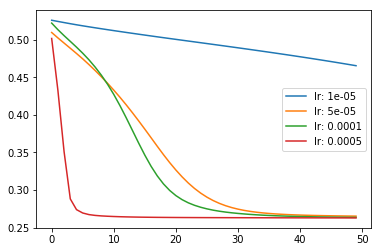

In [9]:
learning_rates = [1e-5,5e-5,1e-4,5e-4]
mseLoss = []
epochs = 50
for i,lr in enumerate(learning_rates):
    print('Learning Rate: {0}'.format(lr))
    model = initialize_model()
    mseLoss.append(train(train_input, train_target, model, epochs, learning_rate=lr))
    
    print('train_error {:.02f}% test_error {:.02f}%'.format(
            compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100,
            compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100))

for i in range(0,len(mseLoss)):
    plt.plot(range(0,epochs),mseLoss[i], label='lr: {0}' .format(learning_rates[i]))
    plt.legend()